In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:

data_path = "../AML-Cytomorphology/"
folders = os.listdir(data_path)
IMG_SIZE = 64
label_encoder = LabelEncoder()


In [3]:

all_images = []
all_labels = []

for folder in folders:
    folder_path = os.path.join(data_path, folder)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img.shape[2] == 4:
            alpha_channel = img[:, :, 3]
            if np.any(alpha_channel < 255):
                continue 
            img = img[:, :, :3]
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        all_images.append(img)
        all_labels.append(folder)
    
all_images = np.array(all_images) / 255.0
numeric_labels = label_encoder.fit_transform(all_labels)
categorical_labels = to_categorical(numeric_labels)

# Splitting the data into training and testing sets
X_train_all, X_test, y_train_all, y_test = train_test_split(
    all_images, 
    categorical_labels, 
    test_size=0.2, 
    random_state=42
)


In [ ]:
def identity_block(X, filters):
    F1, F2 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    return X

In [ ]:
def model_MyRes():
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Initial Conv block with reduced depth
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.2)(x)
    # Only one identity block
    x = identity_block(x, [32, 32])

    # Pooling and Flatten
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)

    # Reduced dense layer size
    x = tf.keras.layers.Dense(len(folders), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model
myres= model_MyRes() 
myres.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def model_myVGG():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(len(folders), activation='softmax')
    ])
    
    return model
myvgg = model_myVGG()
myvgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu',padding='same'),
    Dropout(0.2),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(folders), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Define model checkpointing
model_checkpoint = ModelCheckpoint('../models/best_1.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
for i in range(5):
    model.fit(X_train_all, y_train_all, 
        epochs=10,
        batch_size=32,
        validation_split=0.2, 
        callbacks=[early_stopping, model_checkpoint],
        shuffle= True)
    

In [6]:
model.load_weights('../models/model_9287.h5')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        18496     
                                                        

In [8]:
import h5py

# Open the HDF5 file
with h5py.File('../models/model_9287.h5', 'r') as f:
    print("Root keys:", list(f.keys()))

    model_weights_group = f['model_weights']
    
    # Print keys within the 'model_weights' grou
    print("Keys in 'model_weights' group:", list(model_weights_group.keys()))


Root keys: ['model_weights', 'optimizer_weights']
Keys in 'model_weights' group: ['conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_9', 'dense_4', 'dense_5', 'dropout_10', 'dropout_11', 'dropout_12', 'dropout_7', 'dropout_8', 'dropout_9', 'flatten_2', 'max_pooling2d_5', 'max_pooling2d_6', 'max_pooling2d_7', 'top_level_model_weights']


In [17]:
model.evaluate(X_test, y_test, verbose=1)

114/114 [==============================] - 1s 6ms/step - loss: 0.2828 - accuracy: 0.9287


[0.28282997012138367, 0.9286890029907227]

In [ ]:
model.save('../models/model_9287.h5')

In [3]:
cur_best = tf.keras.models.load_model('../models/model_9287.h5')

# Plot image travelling through the layers

1/1 [==============================] - 1s 864ms/step


C:\Users\shash\AppData\Local\Temp\ipykernel_10956\3186272132.py:32: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
C:\Users\shash\AppData\Local\Temp\ipykernel_10956\3186272132.py:35: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


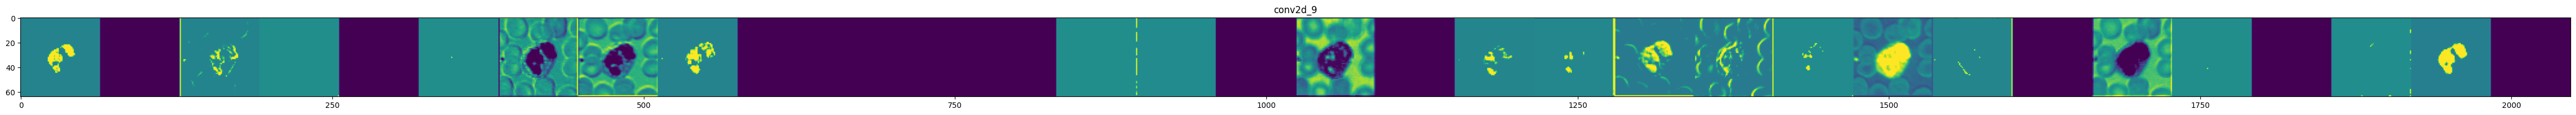

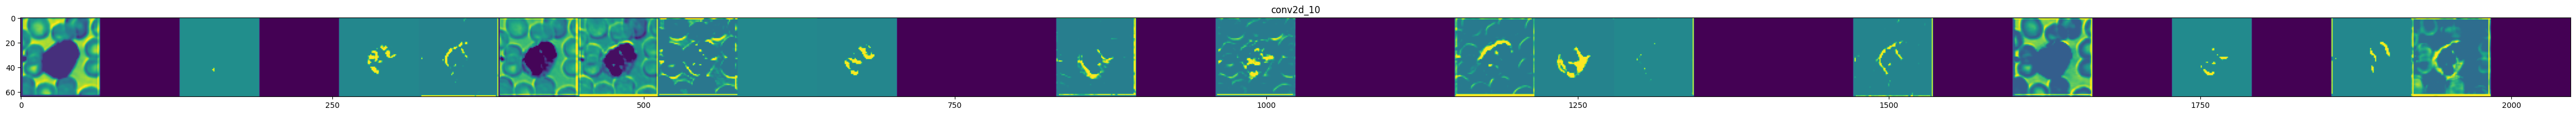

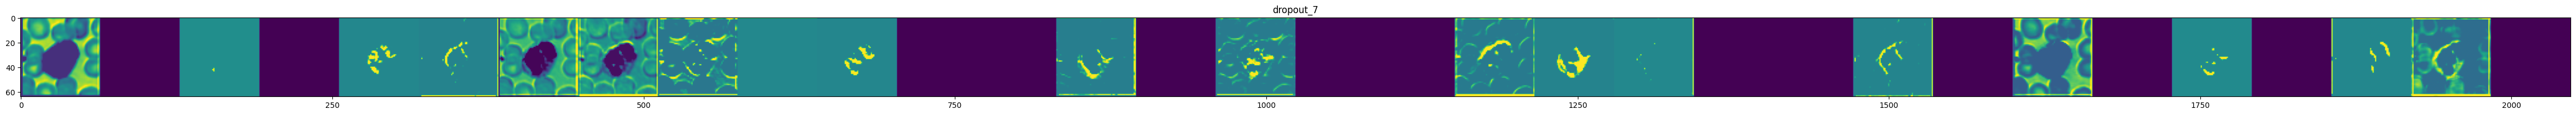

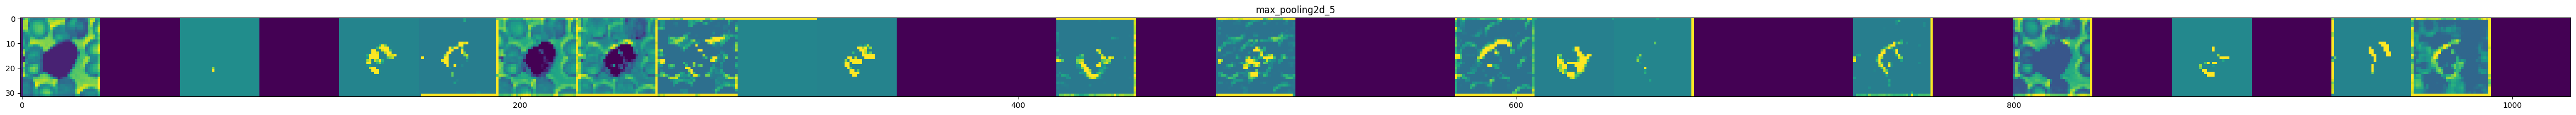

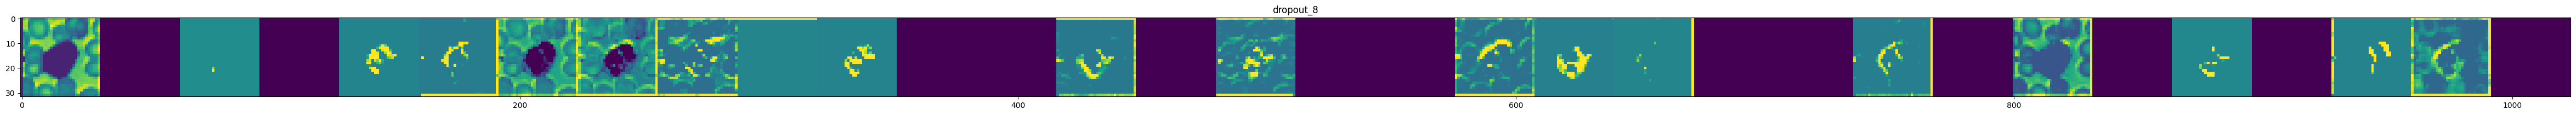

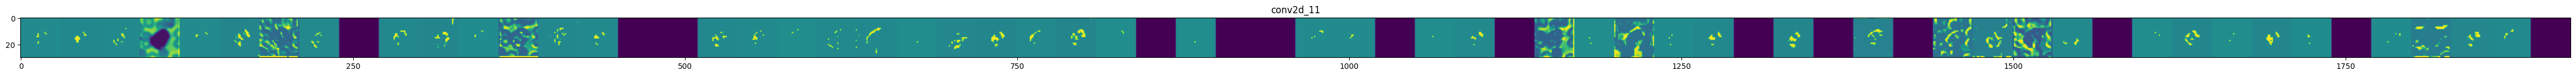

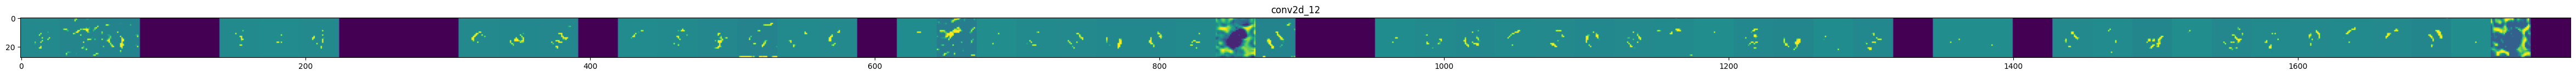

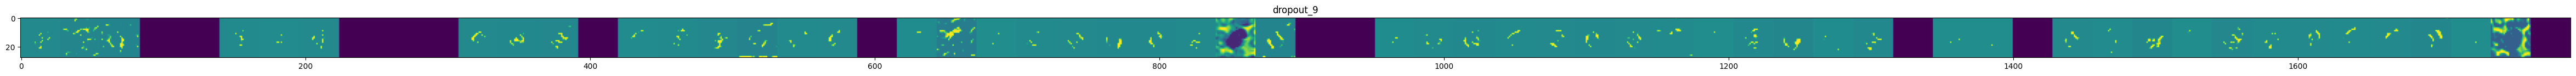

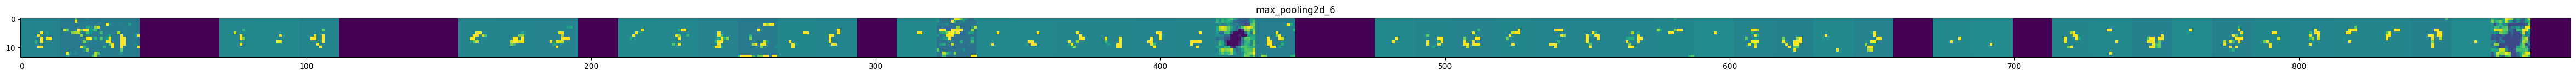

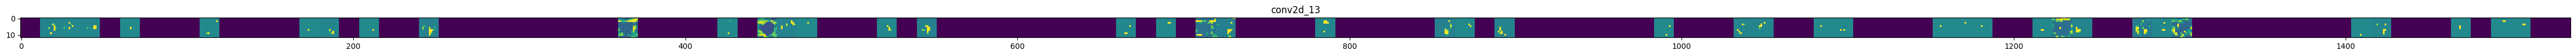

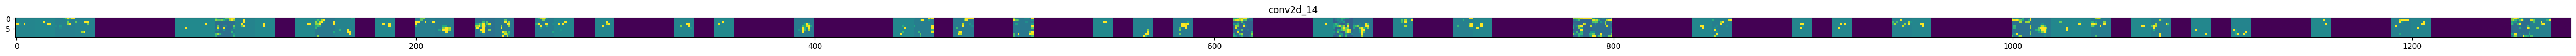

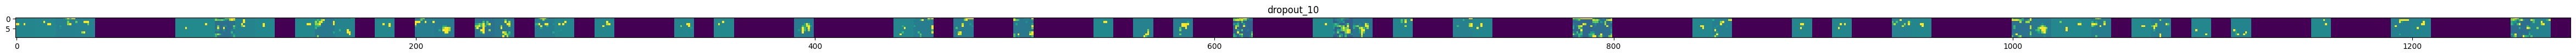

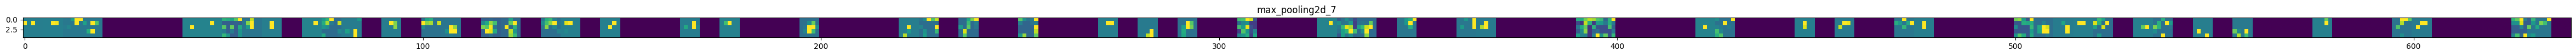

In [12]:
model=cur_best
layer_outputs = [layer.output for layer in model.layers]  
activation_model = Model(inputs=model.input, outputs=layer_outputs)

img_path='../AML-Cytomorphology/BAS/BAS_0001.tiff'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Read image with all channels
if img.shape[2] == 4:  # Check if image has an alpha (transparency) channel
    alpha_channel = img[:, :, 3]
if np.any(alpha_channel < 255):  # Check if any pixel is not fully opaque
    pass  # Skip this image
img = img[:, :, :3]  # Drop the alpha channel to keep only RGB channels
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img=img.astype('float32')/255.0
img = np.expand_dims(img, axis=0)

# Get the feature maps
feature_maps = activation_model.predict(img)

# Plotting
for layer_name, feature_map in zip([layer.name for layer in model.layers], feature_maps):
    if len(feature_map.shape) == 4:
        # Plotting the feature maps
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)
        
        # We will tile the activation channels in this matrix
        display_grid = np.zeros((size, size * n_features))
        
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x
        
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features*3, scale*3))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.savefig('../images/feature_maps/{}.tiff'.format('9287_BAS001_'+layer_name))

In [14]:
[print(layer.name) for layer in model.layers]

conv2d
conv2d_1
dropout
max_pooling2d
dropout_1
conv2d_2
conv2d_3
dropout_2
max_pooling2d_1
conv2d_4
conv2d_5
dropout_3
max_pooling2d_2
flatten
dropout_4
dense
dropout_5
dense_1


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Evaluation

In [16]:
train_loss, train_accuracy = model.evaluate(X_train_all, y_train_all, verbose=1)
print("Training Loss:", train_loss*100)
print("Training Accuracy:", train_accuracy*100)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss*100)
print("Test Accuracy:", test_accuracy*100)

456/456 [==============================] - 2s 5ms/step - loss: 0.1164 - accuracy: 0.9676
Training Loss: 11.63647472858429
Training Accuracy: 96.76268696784973
114/114 [==============================] - 1s 5ms/step - loss: 0.2828 - accuracy: 0.9287
Test Loss: 28.283002972602844
Test Accuracy: 92.86890029907227


In [8]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
class_report = classification_report(y_true, y_pred, labels=np.arange(len(folders)), target_names=folders)
print("Classification Report:")
print(class_report)

114/114 [==============================] - 7s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         BAS       0.40      0.24      0.30        17
         EBO       0.62      0.50      0.55        16
         EOS       0.89      0.88      0.88        80
         KSC       0.00      0.00      0.00         4
         LYA       0.00      0.00      0.00         0
         LYT       0.91      0.95      0.93       765
         MMZ       0.00      0.00      0.00         3
         MOB       0.00      0.00      0.00         3
         MON       0.85      0.85      0.85       344
         MYB       0.00      0.00      0.00         9
         MYO       0.92      0.90      0.91       676
         NGB       0.67      0.18      0.29        22
         NGS       0.97      0.99      0.98      1687
         PMB       0.00      0.00      0.00         5
         PMO       0.40      0.13      0.20        15

   micro avg       0.93      0.93      0.93      3646
  

d:\CancerResearch\Code\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CancerResearch\Code\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CancerResearch\Code\myenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CancerResearch\Code\myenv\

d:\CancerResearch\Code\myenv\lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


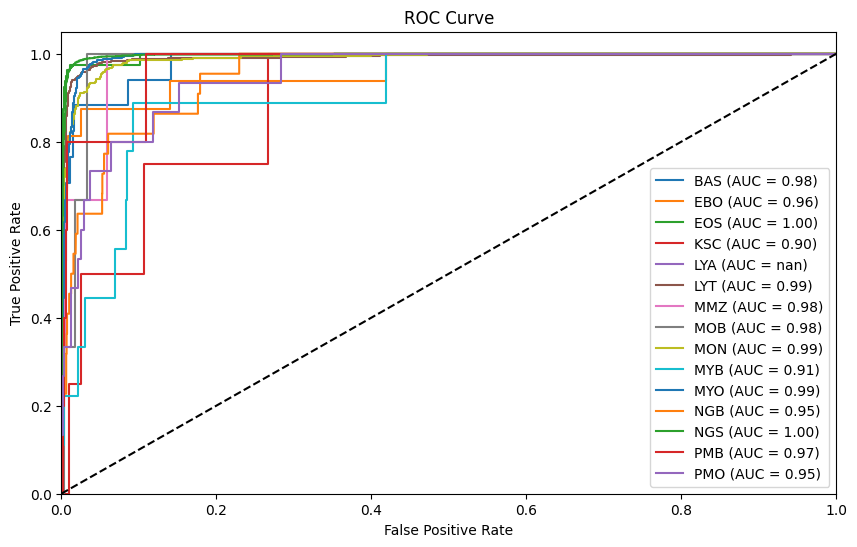

In [31]:
# ROC and AUC

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(folders)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i in range(len(folders)):
    plt.plot(fpr[i], tpr[i], label=f'{folders[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

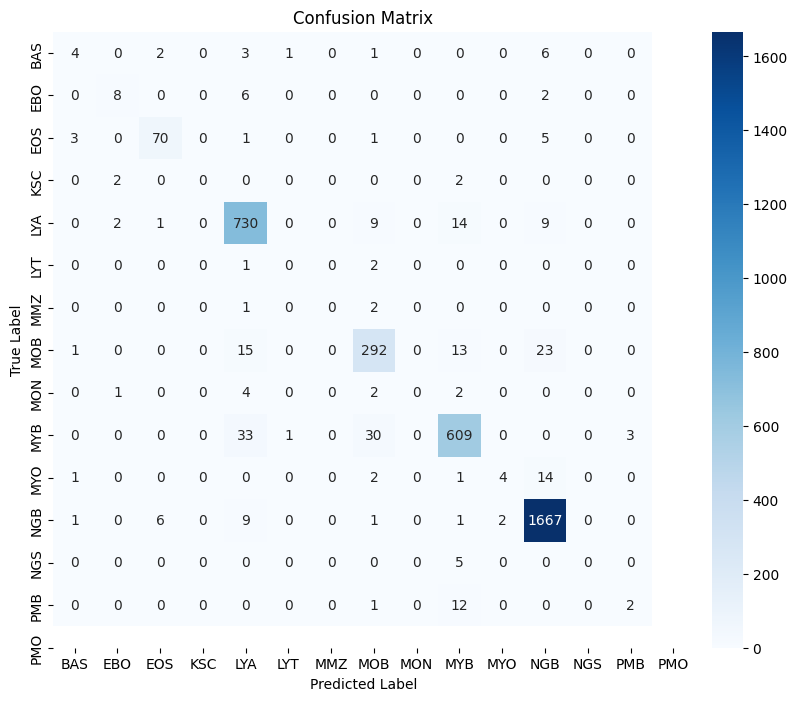

In [34]:
# Plotting the CONFUSION MATRIX
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=folders, yticklabels=folders)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [35]:
1667/np.ceil(0.2*len())

0.9823217442545669

In [37]:
len(categorical_labels)


18226

In [49]:
for folder in folders:
    folder_path = os.path.join(data_path, folder)
    if(folder=='NGS'):
        len_data = len(os.listdir(folder_path))


1667/np.ceil(0.2*len_data)*100

98.23217442545669